<center><h1>MLP training using PSO</h1></center>
<center><h2>Objective: Train the MLP using the Particle Swarm Optimization algorithm for finding weights and biases.</h2></center>

Things we’ll do: 
    1. Create a forward_prop method that will do forward propagation for one particle.
    2. Create an overhead objective function f() that will compute forward_prop() for the whole swarm.

What we’ll be doing then is to create a swarm with a number of dimensions equal to the weights and biases. We will unroll these parameters into an n-dimensional array, and have each particle take on different values. Thus, each particle represents a candidate neural network with its own weights and bias. When feeding back to the network, we will reconstruct the learned weights and biases.

When rolling-back the parameters into weights and biases, it is useful to recall the shape and bias matrices: 
-  Shape of input-to-hidden weight matrix: (4, 20) 
-  Shape of input-to-hidden bias array: (20, )
-  Shape of hidden-to-output weight matrix: (20, 3) 
-  Shape of hidden-to-output bias array: (3, )

By unrolling them together, we have (4∗20)+(20∗3)+20+3=163 parameters, or 163 dimensions for each particle in the swarm.

The negative log-likelihood will be used to compute for the error between the ground-truth values and the predictions. Also, because PSO doesn’t rely on the gradients, we’ll not be performing backpropagation (this may be a good thing or bad thing under some circumstances).

In [3]:
# ! pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pyswarms

     |████████████████████████████████| 104 kB 241 kB/s 


In [17]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

# Import PySwarms
import pyswarms as ps

## Dataset: Iris Dataset

In [18]:
from sklearn.datasets import load_iris

# Load the iris dataset
data = load_iris()

# Store the features as X and the labels as y
X = data.data
y = data.target

In [19]:
from sklearn.preprocessing import StandardScaler
# Data Normalisation 
scale = StandardScaler()
scale.fit(X)
X = scale.transform(X)

In [20]:
X.shape

(150, 4)

In [21]:
np.unique(y)

array([0, 1, 2])

## Forward propagation of the Single Hidden Layer Feed Forward Network with:
### Input data dimension = 4;
### Hidden layer dimension = 20;
### Number of classes = 3

In [22]:
n_inputs = 4
n_hidden = 20  ## We can only modify this!
n_classes = 3

num_samples = len(X)

In [23]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss. It receives a set of parameters that must be
    rolled-back into the corresponding weights and biases.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """
    
    # Roll-back the weights and biases
    W1 = params[0:n_inputs*n_hidden].reshape((n_inputs,n_hidden))
    b1 = params[n_inputs*n_hidden:(n_inputs+1)*n_hidden].reshape((n_hidden,))
    W2 = params[(n_inputs+1)*n_hidden:(n_inputs+n_classes+1)*n_hidden].reshape((n_hidden,n_classes))
    b2 = params[(n_inputs+n_classes+1)*n_hidden:(n_inputs+n_classes+1)*n_hidden+n_classes].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1 (tanh activation) # We can modify this also!
    z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2
    logits = z2          # Logits for Layer 2

    # Compute for the softmax of the logits (Activation for the output layer - SOFTMAX)
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # Output from the network (y_cap)

    # Compute for the negative log likelihood
    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples
    return loss

## Objective function: Error from negative log likelihood

In [24]:

def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

## Global best PSO algorithm for finding the optimal weights and biases:

In [25]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}  ## We can experiment with this!

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=500)

2021-05-16 18:57:19,437 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.00165
2021-05-16 18:57:26,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001648836870427807, best pos: [ 0.21125209  1.44852031  0.46518835  1.30071539  2.96611052  0.9579192
  2.19193772 -2.90824305  2.17749768  2.27043224  2.77841507  1.1469929
  2.19217027  0.59122195  1.35076176  0.12391017  0.80179655 -0.9684688
 -1.55234045  2.90220034 -0.10911241 -2.18977648  0.94273611 -1.64180182
  1.9313411  -2.00678263 -3.55390233  0.49381186  1.99473073 -2.578792
 -1.0849418  -1.16002605  1.18873319  0.65111323  3.55861051 -0.57816433
 -1.13486469  2.01051765  0.32887544  3.50622838  0.73780422  1.95742562
  4.14002809  6.0073774  -2.22213889 -1.66866835  0.90795733 -1.19934212
 -1.06886343  0.04888492 -0.69828943  1.3978161   2.80114713  1.46191562
  1.18195694  0.880269

## Checking the accuracy using the obtained weights and biases from the PSO:

In [26]:
def predict(X, pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    X: numpy.ndarray
        Input Iris dataset
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """

    # Roll-back the weights and biases
    W1 = pos[0:n_inputs*n_hidden].reshape((n_inputs,n_hidden))
    b1 = pos[n_inputs*n_hidden:(n_inputs+1)*n_hidden].reshape((n_hidden,))
    W2 = pos[(n_inputs+1)*n_hidden:(n_inputs+n_classes+1)*n_hidden].reshape((n_hidden,n_classes))
    b2 = pos[(n_inputs+n_classes+1)*n_hidden:(n_inputs+n_classes+1)*n_hidden+n_classes].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2
    logits = z2          # Logits for Layer 2

    y_pred = np.argmax(logits, axis=1)
    return y_pred

## Accuracy:

In [27]:
(predict(X, pos) == y).mean()       ## Training Accuracy

1.0

# Dataset: XOR dataset

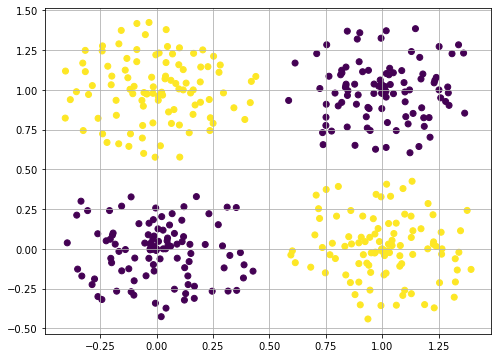

In [28]:
data = np.genfromtxt("XOR_dataset.csv",delimiter=',')

plt.figure(figsize=(8,6))
plt.scatter(data[:,0],data[:,1],c=data[:,2])
plt.grid()
plt.show()

In [29]:
X = data[:,:-1] ; y = [int(i) for i in data[:,-1]]

In [30]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X)
X = scale.transform(X)

__Network Architecture__

In [31]:
n_inputs = 2
n_hidden = 7
n_classes = 2

num_samples = len(X)

__Training the MLP Classifier__

In [32]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.95}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=200)

2021-05-16 19:00:52,590 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.95}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=1.26e-9
2021-05-16 19:00:56,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.263510206146176e-09, best pos: [ -1.86634984  12.87633149   1.62559212   2.43483377   1.88742126
  -1.42914913   3.20431631   1.2465939    2.19186245   3.75212271
  -3.70699522   2.15161058   4.15681037   4.23311206   1.25451789
   7.53178754   3.10060478   2.67267901  -2.19470863  -7.035775
   4.85172045  41.33138497  -4.27074048   2.59596397   1.50198412
 -12.39306941   4.42548546   4.78526105 -40.90824315  -0.54044117
 -56.10816858   1.09884458   0.99083535   0.40953551   5.91238799
   0.9834783   -3.69738737]


__Computing the overall Accuracy of the Classifier__

In [33]:
(predict(X, pos) == y).mean()

1.0